# Lab 6 

Ali Tejani, amt3639

Caroline Yao, chy253

Allen Hwang, ah45755

## Problem 1

### Estimating beta with linear regression

In [498]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge

In [499]:
n = 51
p = 50

In [688]:
def estimate_b(reg,n,p,seed=None):
    # seed rng so that we can compare different models
    np.random.seed(seed=seed)
    b_hat = []
    for _ in range(50):
        # create different distributions and fit the model
        X = np.random.normal(0,1,(n,p))
        e = np.random.normal(0,.25,(n,1))
        b = np.ones((p,1))
        y = np.dot(X,b) + e
        reg.fit(X,y)
        reg.coef_
        b_hat.append(reg.coef_)
    b_hat = np.array(b_hat)
    print type(reg).__name__,':'
    if isinstance(reg,Ridge):
        print 'alpha',reg.get_params()['alpha']
    print 'Average of B values: ',b_hat.mean(axis=0).mean()
    print 'Variance of B values: ',b_hat.var(axis=0).mean()

In [689]:
estimate_b(LinearRegression(fit_intercept=False),n,p,seed=3)

LinearRegression :
Average of B values:  1.00014392364
Variance of B values:  0.000118771478505


In [690]:
alphas = [0.01,0.1,1,10,100,1000]
for a in alphas:
    estimate_b(Ridge(alpha=a),n,p,seed=3)

Ridge :
alpha 0.01
Average of B values:  1.00012448614
Variance of B values:  0.00011900454366
Ridge :
alpha 0.1
Average of B values:  0.999954072731
Variance of B values:  0.000118934888148
Ridge :
alpha 1
Average of B values:  0.998253416358
Variance of B values:  0.000118526115805
Ridge :
alpha 10
Average of B values:  0.981587024557
Variance of B values:  0.000140953905645
Ridge :
alpha 100
Average of B values:  0.842796644902
Variance of B values:  0.00159701299159
Ridge :
alpha 1000
Average of B values:  0.35851631145
Variance of B values:  0.00437790390985


Linear regression gives us an acurate value when beta is simple. Ridge regression gives us increasingly worse values for beta as we increase alpha. However, ridge regression also gives a lower variance in certain ranges for alpha, which means the values are more closer together and more simple.

## Problem 2: Chapter 6, Problem 9

### a.  Split the data set into a training set and a test set

In [691]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
np.random.seed()

In [700]:
# read data, clean up, and split to train and test data, 80/20
college = pd.read_csv('College.csv',index_col=0)
college['Private'] = college['Private'].replace('Yes',1).replace('No',0)
collegeX = college[[i for i in college.axes[1] if i != 'Apps']]
collegeY = college['Apps']
college_trainX,college_testX,college_trainY,college_testY = train_test_split(collegeX,collegeY)
college_trainX = scale(college_trainX)
college_testX = scale(college_testX)

### b. Fit a linear model using least squares on the training set, and report the test error obtained

In [701]:
def reg_score(reg):
    reg.fit(college_trainX,college_trainY)
    print 'R**2:',reg.score(college_testX,college_testY)
    print 'MSE:',mean_squared_error(reg.predict(college_testX),college_testY)

In [702]:
reg_score(LinearRegression())

R**2: 0.844531192312
MSE: 3669090.75362


### c.  Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [703]:
from sklearn.linear_model import RidgeCV,LassoCV
ridge_reg = RidgeCV(alphas=[0.001,0.005,0.01,0.05,0.1,0.5,1,10,100])
reg_score(ridge_reg)
print 'alpha chosen:',ridge_reg.alpha_

R**2: 0.842449377931
MSE: 3718221.9331
alpha chosen: 1.0


### d.  Fit a lasso model on the training set, with λ chosen by crossvalidation. Report the test error obtained, along with the number of non-zero coefficient estimates.

In [704]:
lasso_reg = LassoCV(alphas=[0.0001,0.001,0.005,0.01,0.05,0.1,0.5,1,10,100])
reg_score(lasso_reg)
print 'alpha chosen:',lasso_reg.alpha_
print 'number of zeros:',np.count_nonzero(np.isclose(lasso_reg.coef_,0))

R**2: 0.837824628669
MSE: 3827366.81566
alpha chosen: 10.0
number of zeros: 1


### e. Fit a PCR model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation

In [717]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
pca = PCA()
linreg = LinearRegression()
# pipe pca to linear regression
pipe = Pipeline(steps=[('pca',pca),('linear',linreg)])

In [719]:
# run cv on our model, using from 1 to 17 features
gscv = GridSearchCV(pipe, dict(pca__n_components=np.arange(1,college_trainX.shape[1]+1)),cv=10)
reg_score(gscv)
print 'number of components used:',gscv.best_params_['pca__n_components']

R**2: 0.844531192312
MSE: 3669090.75362
number of components used: 17


### f. Fit a PLS model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.

In [720]:
from sklearn.cross_decomposition import PLSRegression

In [721]:
from sklearn.preprocessing import scale 
pls = PLSRegression()
# run cv on our model, using from 1 to 17 features
gscv = GridSearchCV(pls, dict(n_components=np.arange(1,college_trainX.shape[1]+1)),cv=10)
reg_score(gscv)
print 'number of components used:',gscv.cv_results_['rank_test_score'][0]

R**2: 0.84408571974
MSE: 3679603.98337
number of components used: 17


### g. Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?

The best scores are received for linear regression and for PCR/PLS with all components. This means that the output fits closely with the features. Linear regression is the best model for this data, since it is the most accurate without needing the extra work of performing pca

# Problem 3
## A) Model fitting

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [38]:
boston = pd.read_csv("boston.csv")
X = boston.loc[:, "zn":"medv"]
y = boston["crim"]

X_train, X_test, y_train, y_test = train_test_split(X, y)
boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Using Lasso

In [39]:
from sklearn.linear_model import LassoCV

In [52]:
lasso = LassoCV(alphas = (np.arange(0.01, 10, 0.01)), cv=5)
lasso.fit(X_train, y_train)
print lasso.score(X_train, y_train, sample_weight=None)
mean_squared_error(y_test, lasso.predict(X_test))

0.430468734921


8.2636710286494743

### Using Ridge

In [41]:
from sklearn.linear_model import RidgeCV

In [54]:
ridge = RidgeCV(alphas = (np.arange(0.01, 10, 0.01)), cv=5)
ridge.fit(X_train, y_train)
print ridge.score(X_train, y_train, sample_weight=None)
mean_squared_error(y_test, ridge.predict(X_test))

0.439338008807


9.2055666186043528

### Using PCR

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold, cross_val_score

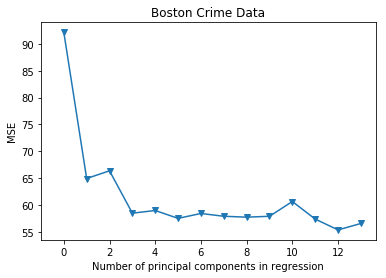

In [44]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits = 10, shuffle=True)
regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 13 principle components, adding one component at the time.
for i in np.arange(1, 14):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Boston Crime Data')
plt.xlim(xmin=-1)
plt.show()

The above graph shows that the training MSE can be reduced by doing regression on 12 components

In [45]:
from sklearn.cross_decomposition import PLSRegression

In [55]:
pls = PLSRegression(n_components=8)
pls.fit(scale(X_train), y_train)
print pls.score(X_train, y_train)
mean_squared_error(y_test, pls.predict(scale(X_test)))

-3835.80200826


15.83575339306544

In [56]:
pls = PLSRegression(n_components=12)
pls.fit(scale(X_train), y_train)
print pls.score(X_train, y_train)
mean_squared_error(y_test, pls.predict(scale(X_test)))

-4875.75409591


15.754485255681042

The model that gives the best MSE is the LassoCV.  This means that the error between each of the predictions is lower than the other models.  It should be noted that the R-Squared of the all the data, RidgeCV did slightly better.  This means that the RidgeCV model actually factors more the data given even though the average error of each of their prediction is much higher.  Finally, with PCA, it has both high MSE (meaning each prediction has a higher amount of error) and a negative score( which means that for this error, the model doesn't account for any of it), thus PCA isn't the best regarding this data.

## B+ C) Model Selection and Relevant features
Based on the data given, the model that seems to perform well on this data set is RidgeCV.  That is because even thought the MSE was higher than Lasso, it also has a higher R-Sqaured.  This means that the Ridge model more closely fits with the given data, and is also able to "make up" the difference of the MSE.  The model selected uses all features available to the data, as shown in the graph above that the lowest MSE of the data hovers aroudn 12-13 features.